In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from torch import nn
import pickle
from sklearn.metrics import mean_squared_error

## Text data preprocessing

In [3]:
path = Path.cwd()/'data'/'gasoline.csv'
data = pd.read_csv(path)
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
oil_price = data[['OT', 'Final_Search_2']]
oil_price.columns = ['price', 'news']
oil_price = oil_price.loc["2003-01-01":]
print(oil_price.shape)

(1113, 2)


In [4]:
def trim_sentence(sentence):
    clean = re.sub(r'^Available facts are as follows:\s*', "", sentence)
    return clean
def remove_source(sentence):
    clean = re.sub(r'\[Source(:.*?)?\]', "", sentence)
    return clean
def remove_space(sentence):
    clean = re.sub(r";", " ", sentence)
    clean = re.sub(r"\s+", " ", clean).strip()
    return clean
def preprocess_text(sentence, date, price):
    clean = trim_sentence(sentence)
    clean = remove_source(clean)
    clean = remove_space(clean)
    clean = f"today price {price}. " + f"today is {date.year}-{date.month}-{date.day}. " + clean 
    return clean

In [5]:
oil_price.news = list(map(preprocess_text, oil_price.news, oil_price.index, oil_price.price))

In [7]:
oil_price.news.iloc[100]

"today price 1.956. today is 2004-12-6. 2004-11-29: The price of oil and natural gas has a significant impact on the economy, particularly in regions that rely heavily on these energy sources. The cost of wind power is decreasing, making it a more viable alternative to fossil fuels. The gasoline tax accounts for a significant portion of the retail gasoline price. 2004-11-22: The United States' oil production peaked in 1970, as predicted by Hubbert's theory. In the case of crude oil, the amount obtainable from fat was used as fuel for lamps. The price of oil affects the investment and production of hydrocarbons. In November 2004, oil price pressures eased due to increased assurances about the adequacy of US winter fuel supplies."

In [12]:
tr_size = int(oil_price.shape[0]*0.5)
test_size = oil_price.shape[0] - tr_size
train, test = oil_price[:tr_size], oil_price[tr_size:]
print(train.shape)
print(test.shape)

(556, 2)
(557, 2)


In [14]:
scaler = StandardScaler()
scaler.fit(train.price.values.reshape((-1,1)))

StandardScaler()

In [16]:
train['price'] = scaler.transform(train.price.values.reshape((-1,1)))
test['price'] = scaler.transform(test.price.values.reshape((-1,1)))

/tmp/ipykernel_9613/2082512033.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['price'] = scaler.transform(train.price.values.reshape((-1,1)))
/tmp/ipykernel_9613/2082512033.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['price'] = scaler.transform(test.price.values.reshape((-1,1)))


## Custom Dataset

In [18]:
class CustomDataset(Dataset):
    def __init__(self, data, tokeniser, lag=7):
        """
        Args:
            data(np.ndarray): dim is (N , 1)
            lag(int): context or window length
        Remarks:
            Max length of token is selected 512 with appropriate padding.
        """
        self.X = list()
        sentences = list()
        self.y = list()
        for i in range(len(data) - lag):
            x = data[i : i + lag, 0]
            y = data[i + lag, 0]
            self.X.append(x.flatten())
            self.y.append(y)
            sentences.append(data[i+lag, 1])
        self.X = torch.tensor(np.array(self.X, dtype=np.float32), dtype=torch.float32)
        self.y = torch.tensor(np.array(self.y, dtype=np.float32), dtype=torch.float32)
        self.tokens = list()
        for text in sentences:
            ids = tokeniser.encode(text, max_length=512, truncation=True, padding='max_length')
            self.tokens.append(ids)
        self.tokens = torch.tensor(self.tokens, dtype=torch.long)
        mask_fn = lambda x: 1 if x!=0 else 0
        self.attn_masks = torch.clone(self.tokens)
        self.attn_masks.apply_(mask_fn)
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.tokens[idx], self.attn_masks[idx], self.y[idx]      

## Model Building

In [22]:
class CustomModel(nn.Module):
    def __init__(self, in_size, hid_size):
        super(CustomModel, self).__init__()
        # Bert with last custom layer trainable
        self.bert = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-uncased')
        for param in self.bert.parameters():
            param.requires_grad = False
        self.bert.pooler.dense = nn.Linear(768, 1, bias=True)
        self.bert.pooler.activation = nn.Sigmoid()
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=in_size,
            hidden_size=hid_size,
            batch_first=True
            # proj_size=1,
        )
        self.proj = nn.Linear(in_features=hid_size, out_features=1)

    def forward(self, x, tokens, mask):
        y_bert = self.bert(tokens, attention_mask=mask)
        y_bert = y_bert.pooler_output
        y_lstm, _ = self.lstm(x)
        y_lstm = self.proj(y_lstm)
        y_pred = y_lstm + y_bert
        return y_pred

In [24]:
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')

Using cache found in /home/arnab/.cache/torch/hub/huggingface_pytorch-transformers_main


In [33]:
def train_model(
    model,
    optimiser,
    loss_fn,
    epochs,
    batch,
    data,
    lag,
    tokeniser, 
    device
):
    dataset = CustomDataset(data, tokeniser, lag)
    loader = DataLoader(dataset, batch_size=batch)
    tr_losses = list()
    val_losses = list()
    model.to(device)

    for i in range(epochs):
        train_loss = list()
        val_loss = list()
        for j, (X, tokens, masks, y) in enumerate(loader):
            n = X.shape[0]
            tr_size = int(n*0.9)
            y = y.reshape((-1,1))
            X, tokens, masks, y = X.to(device), tokens.to(device), masks.to(device), y.to(device)
            X_train, tokens_train = X[:tr_size, :],tokens[:tr_size, :] 
            mask_train, y_train = masks[:tr_size, :], y[:tr_size, :]
            X_val, tokens_val,  = X[tr_size:, :], tokens[tr_size:, :] 
            mask_val, y_val = masks[tr_size:, :], y[tr_size:, :]

            y_pred = model(X_train, tokens_train, mask_train)
            loss = loss_fn(y_pred, y_train)

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            train_loss.append(loss.item())
            if (j+1)%3 == 0:
                print(f"Epoch - {i+1}, step - {j+1}, train_loss = {loss.item()}")
            with torch.no_grad():
                y_pred_val = model(X_val, tokens_val, mask_val)
                val_loss.append(loss_fn(y_pred_val, y_val).item())
        tr_losses.append(np.mean(train_loss))
        val_losses.append(np.mean(val_loss))
    
    return tr_losses, val_losses

In [37]:
def train_10_epochs(model):
    batch = 128
    epochs = 10
    # lags = list(range(4,12))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()
    tr_losses, val_losses = train_model(model, optimiser, loss_fn, epochs,
                batch, train.values, lag, tokenizer, device)
    return tr_losses, val_losses

In [35]:
model = CustomModel(in_size=lag, hid_size=10)

Using cache found in /home/arnab/.cache/torch/hub/huggingface_pytorch-transformers_main


In [39]:
training_loss, validation_loss = list(), list()
loss1, loss2 = train_10_epochs(model)
training_loss.extend(loss1)
validation_loss.extend(loss2)

Epoch - 1, step - 3, train_loss = 0.7409502267837524
Epoch - 2, step - 3, train_loss = 0.6881715059280396
Epoch - 3, step - 3, train_loss = 0.6508200764656067
Epoch - 4, step - 3, train_loss = 0.6159448027610779
Epoch - 5, step - 3, train_loss = 0.5832130908966064
Epoch - 6, step - 3, train_loss = 0.5530732274055481
Epoch - 7, step - 3, train_loss = 0.5257119536399841
Epoch - 8, step - 3, train_loss = 0.5008183717727661
Epoch - 9, step - 3, train_loss = 0.4776493012905121
Epoch - 10, step - 3, train_loss = 0.4553825259208679


In [43]:
loss1, loss2 = train_10_epochs(model)
training_loss.extend(loss1)
validation_loss.extend(loss2)

Epoch - 1, step - 3, train_loss = 0.4260759949684143
Epoch - 2, step - 3, train_loss = 0.4029741883277893
Epoch - 3, step - 3, train_loss = 0.37896281480789185
Epoch - 4, step - 3, train_loss = 0.357134073972702
Epoch - 5, step - 3, train_loss = 0.3394632637500763
Epoch - 6, step - 3, train_loss = 0.3252420723438263
Epoch - 7, step - 3, train_loss = 0.31181618571281433
Epoch - 8, step - 3, train_loss = 0.29771924018859863
Epoch - 9, step - 3, train_loss = 0.28379490971565247
Epoch - 10, step - 3, train_loss = 0.2713209390640259


In [57]:
loss1, loss2 = train_10_epochs(model)
training_loss.extend(loss1)
validation_loss.extend(loss2)

Epoch - 1, step - 3, train_loss = 0.2601439356803894
Epoch - 2, step - 3, train_loss = 0.2511632740497589
Epoch - 3, step - 3, train_loss = 0.24226246774196625
Epoch - 4, step - 3, train_loss = 0.23543603718280792
Epoch - 5, step - 3, train_loss = 0.2301863431930542
Epoch - 6, step - 3, train_loss = 0.22496463358402252
Epoch - 7, step - 3, train_loss = 0.2194748818874359
Epoch - 8, step - 3, train_loss = 0.21428550779819489
Epoch - 9, step - 3, train_loss = 0.20949392020702362
Epoch - 10, step - 3, train_loss = 0.20485319197177887


In [63]:
loss1, loss2 = train_10_epochs(model)
training_loss.extend(loss1)
validation_loss.extend(loss2)

Epoch - 1, step - 3, train_loss = 0.20438842475414276
Epoch - 2, step - 3, train_loss = 0.19864116609096527
Epoch - 3, step - 3, train_loss = 0.19232730567455292
Epoch - 4, step - 3, train_loss = 0.18697085976600647
Epoch - 5, step - 3, train_loss = 0.18188107013702393
Epoch - 6, step - 3, train_loss = 0.17715103924274445
Epoch - 7, step - 3, train_loss = 0.1720883995294571
Epoch - 8, step - 3, train_loss = 0.16675978899002075
Epoch - 9, step - 3, train_loss = 0.1618059128522873
Epoch - 10, step - 3, train_loss = 0.1572655588388443


In [73]:
loss1, loss2 = train_10_epochs(model)
training_loss.extend(loss1)
validation_loss.extend(loss2)

Epoch - 1, step - 3, train_loss = 0.15821319818496704
Epoch - 2, step - 3, train_loss = 0.15047447383403778
Epoch - 3, step - 3, train_loss = 0.14602980017662048
Epoch - 4, step - 3, train_loss = 0.14223264157772064
Epoch - 5, step - 3, train_loss = 0.13697560131549835
Epoch - 6, step - 3, train_loss = 0.13250677287578583
Epoch - 7, step - 3, train_loss = 0.1283145397901535
Epoch - 8, step - 3, train_loss = 0.12387034296989441
Epoch - 9, step - 3, train_loss = 0.1195925772190094
Epoch - 10, step - 3, train_loss = 0.11541923880577087


In [79]:
loss1, loss2 = train_10_epochs(model)
training_loss.extend(loss1)
validation_loss.extend(loss2)

Epoch - 1, step - 3, train_loss = 0.11551350355148315
Epoch - 2, step - 3, train_loss = 0.11096567660570145
Epoch - 3, step - 3, train_loss = 0.10622014105319977
Epoch - 4, step - 3, train_loss = 0.10080891847610474
Epoch - 5, step - 3, train_loss = 0.09616127610206604
Epoch - 6, step - 3, train_loss = 0.09196218103170395
Epoch - 7, step - 3, train_loss = 0.08808332681655884
Epoch - 8, step - 3, train_loss = 0.08385781943798065
Epoch - 9, step - 3, train_loss = 0.08013235032558441
Epoch - 10, step - 3, train_loss = 0.07667692005634308


In [89]:
loss1, loss2 = train_10_epochs(model)
training_loss.extend(loss1)
validation_loss.extend(loss2)

Epoch - 1, step - 3, train_loss = 0.07566991448402405
Epoch - 2, step - 3, train_loss = 0.07209610939025879
Epoch - 3, step - 3, train_loss = 0.06875580549240112
Epoch - 4, step - 3, train_loss = 0.06483656167984009
Epoch - 5, step - 3, train_loss = 0.06119461730122566
Epoch - 6, step - 3, train_loss = 0.05780947208404541
Epoch - 7, step - 3, train_loss = 0.05464370176196098
Epoch - 8, step - 3, train_loss = 0.051780980080366135
Epoch - 9, step - 3, train_loss = 0.04901053011417389
Epoch - 10, step - 3, train_loss = 0.04655234143137932


In [98]:
loss1, loss2 = train_10_epochs(model)
training_loss.extend(loss1)
validation_loss.extend(loss2)

Epoch - 1, step - 3, train_loss = 0.04532845318317413
Epoch - 2, step - 3, train_loss = 0.04338905215263367
Epoch - 3, step - 3, train_loss = 0.04314214363694191
Epoch - 4, step - 3, train_loss = 0.039414070546627045
Epoch - 5, step - 3, train_loss = 0.03794245049357414
Epoch - 6, step - 3, train_loss = 0.035714760422706604
Epoch - 7, step - 3, train_loss = 0.034196916967630386
Epoch - 8, step - 3, train_loss = 0.03283248096704483
Epoch - 9, step - 3, train_loss = 0.03125527873635292
Epoch - 10, step - 3, train_loss = 0.030152907595038414


In [107]:
loss1, loss2 = train_10_epochs(model)
training_loss.extend(loss1)
validation_loss.extend(loss2)

Epoch - 1, step - 3, train_loss = 0.029497934505343437
Epoch - 2, step - 3, train_loss = 0.028395498171448708
Epoch - 3, step - 3, train_loss = 0.030022775754332542
Epoch - 4, step - 3, train_loss = 0.026317346841096878
Epoch - 5, step - 3, train_loss = 0.025353236123919487
Epoch - 6, step - 3, train_loss = 0.024249203503131866
Epoch - 7, step - 3, train_loss = 0.02332703024148941
Epoch - 8, step - 3, train_loss = 0.023076843470335007
Epoch - 9, step - 3, train_loss = 0.02197479084134102
Epoch - 10, step - 3, train_loss = 0.02157643809914589


In [109]:
with open('models/lstm_bert1_90ep.pkl', 'wb') as f:
    pickle.dump(model, f)
    f.close()

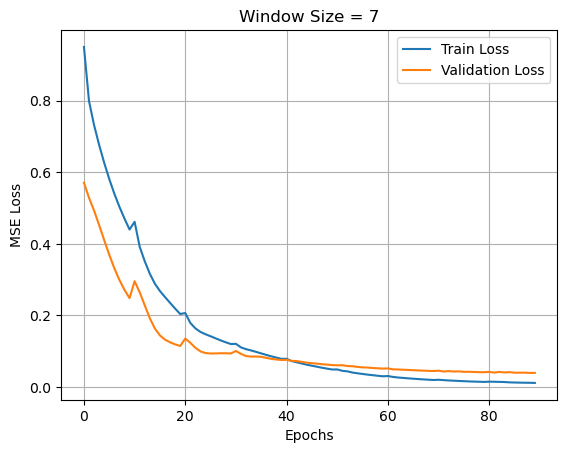

In [113]:
plt.plot(training_loss, label="Train Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.legend()
plt.title(f"Window Size = {lag}")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.grid()
plt.show()

In [115]:
# validation_loss[::-1][0:5]

## Inference

In [119]:
testloader = DataLoader(CustomDataset(test.values,tokenizer, lag=7), batch_size=128)
with open('models/lstm_bert1_90ep.pkl', 'rb') as f:
    model = pickle.load(f)
    f.close()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
actuals = list()
predictions = list()

for X, tokens, masks, y in testloader:
    X, tokens, masks = X.to(device), tokens.to(device), masks.to(device)
    y_pred = model(X, tokens, masks)
    y = y.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    y = y.reshape((-1,1))
    y = scaler.inverse_transform(y)
    y_pred = scaler.inverse_transform(y_pred)
    actuals.extend(y.flatten())
    predictions.extend(y_pred.flatten())


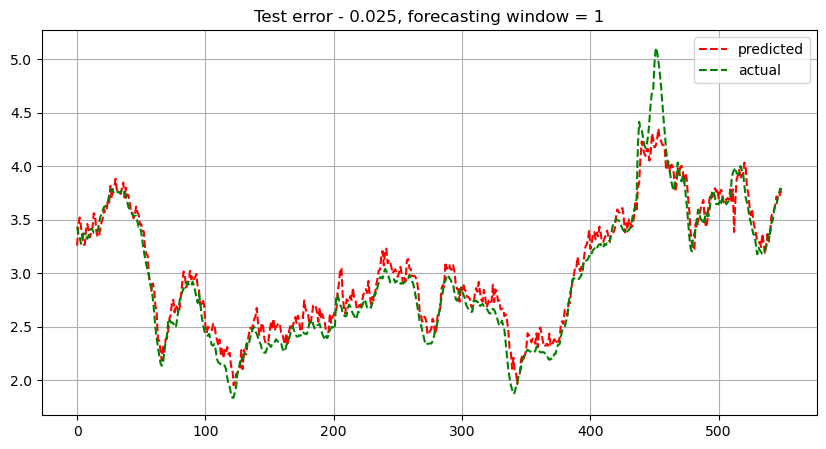

In [121]:
plt.figure(figsize=(10,5))
plt.plot(predictions, 'r--', label='predicted' )
plt.plot(actuals, 'g--', label='actual')
plt.legend()
test_error = mean_squared_error(predictions, actuals)
plt.grid()
plt.title(f"Test error - {test_error:0.3f}, forecasting window = 1")
plt.show()

In [277]:
class ModelInference:
    def __init__(self, model, device, tokeniser):
        self.model = model
        self.device = device
        self.model.to(device)
        self.tokeniser = tokeniser

    def predict(self, x, tokens, mask, window=2):
        """
        Args:
            x (torch.tensor or np.ndarray): dimension (1, window_length) or (window_length, )
        Returns:
            y_pred(np.ndarray): dimension (1, window)
        """
        inp = (x.flatten()).tolist()
        inp_tokens = (tokens.flatten()).tolist()
        mask = torch.unsqueeze(mask, 0)
        pred = list()
        for _ in range(window):
            x = torch.tensor(np.array(inp), dtype=torch.float32)
            tokens = torch.tensor(np.array(inp_tokens), dtype=torch.long)
            x = torch.unsqueeze(x, 0)
            tokens = torch.unsqueeze(tokens, 0)
            x, tokens, mask = x.to(self.device), tokens.to(self.device), mask.to(self.device)
            y_pred = model(x, tokens, mask)
            y_pred = y_pred.item()
            pred.append(y_pred)
            inp.pop(0)
            inp.append(y_pred)
            # modify tokens
            new = f"today price {round(y_pred, 2)}"
            new_tokens = self.tokeniser.encode(new)
            new_tokens.pop(-1) # remove [SEP] token
            for i,new in enumerate(new_tokens):
                inp_tokens[i] = new
        pred = np.array(pred)
        return pred

In [283]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inference = ModelInference(model, device, tokenizer)

In [285]:
testdataset = CustomDataset(test.values, tokenizer, lag=7)

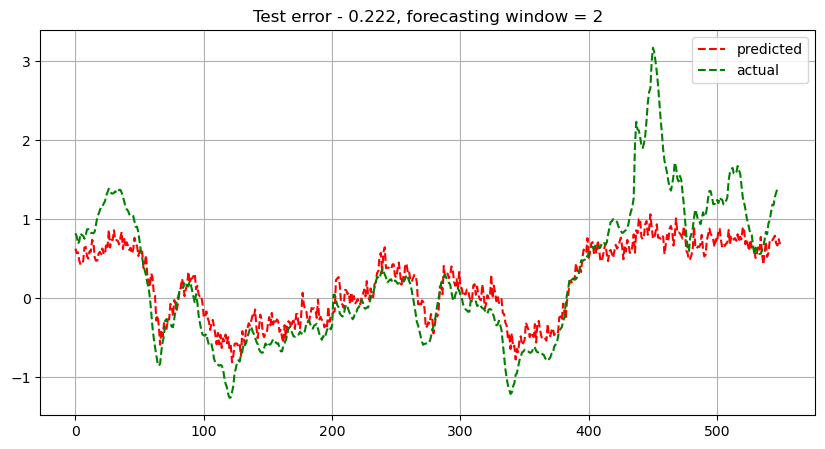

In [286]:
window = 2
actual = list()
predicted = list()
for x, tokens, mask, y in testdataset:
    # print(x.shape, tokens.shape, mask.shape)
    y_pred = inference.predict(x, tokens, mask, window)[-1]
    actual.append(y.item())
    predicted.append(y_pred)
actual = actual[window-1:]
actual = np.array(actual)
predicted = np.array(predicted)
plt.figure(figsize=(10,5))
plt.plot(predicted, 'r--', label='predicted' )
plt.plot(actual, 'g--', label='actual')
plt.legend()
test_error = mean_squared_error(actual, predicted[0:-window+1])
plt.title(f"Test error - {test_error:0.3f}, forecasting window = {window}")
plt.grid()
plt.show()